In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import math 
from tqdm import tqdm
import gymnasium as gym
from gym import spaces
from gym.utils import seeding
import seaborn as sns

colors = sns.color_palette('colorblind')
np.random.seed(2025)

In [3]:
def uniform_sampling(T, K, means):
    rewards = np.zeros(K)
    for k in range(K):
        rewards[k] = np.sum(np.random.binomial(1, means[k], T // K))
    empirical_means = rewards / (T//K)
    return rewards, empirical_means

In [4]:
def successive_rejects(T, K, means):
    A = np.array(list(range(1, K+1)))
    REMOVE = []
    log_bar_K = 1/2 + np.sum([1/k for k in range(2, K+1)])
    n0 = 0
    for j in range(1, K):
        empirical_means = np.zeros(K)
        for index in REMOVE:
            empirical_means[index] = np.inf
        nj = math.floor((T-K) / (log_bar_K * (K + 1 - j)))
        for index, element in enumerate(A):
            if index not in REMOVE:
                empirical_means[index] = np.sum(np.random.binomial(1, means[index], nj)) / nj
        REMOVE.append(np.argmin(empirical_means))
    indices = []
    for ind in list(range(K)):
        if ind not in REMOVE:
            indices.append(ind)
    assert len(indices)==1
    return indices[0]

In [5]:
def run_experience(algorithm, T, K, means, n_iter=10**4):
    counter = np.zeros(K)
    for n in tqdm(range(n_iter)):
        if algorithm=="uniform_sampling":
            rewards, empirical_means = uniform_sampling(T, K, means)
            best_arm = np.argmax(empirical_means) 
        else:
            best_arm = successive_rejects(T, K, means)
        counter[best_arm] += 1
    counter /= n_iter
    p = 1 - np.sum(counter[1:])
    return p

100%|██████████| 10000/10000 [00:05<00:00, 1800.19it/s]


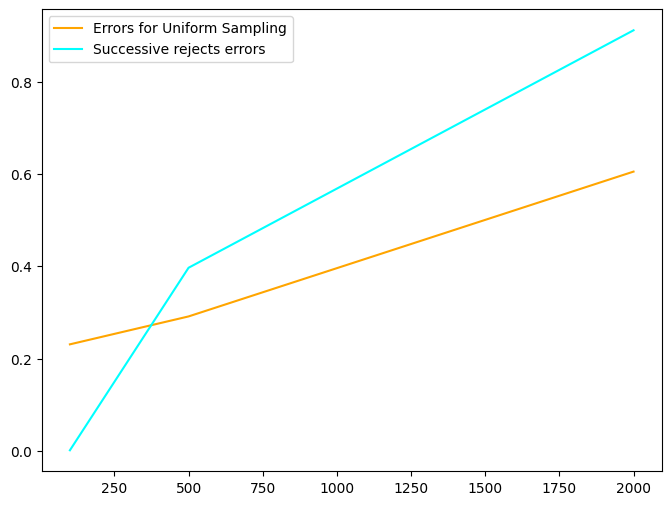

In [6]:
K = 20
means = [0.6] + [0.5] * (K-1)
Ts = [100, 500, 2000]
Usampling_errors = []
Srejects_errors = []

for T in Ts:
    p_error = run_experience(algorithm="uniform_sampling", T=T, K=K, means=means, n_iter=10**4)
    Usampling_errors.append(p_error)
    p_error_sr = run_experience(algorithm="successive_rejects", T=T, K=K, means=means, n_iter=10**4)
    Srejects_errors.append(p_error_sr)
    #print(f"\nT = {T}")
    #print(f"Probability of error for uniform sampling is: {p_error}")
    #print(f"Probability of error for successive rejects is: {p_error_sr}")

plt.figure(figsize=(8,6))
plt.plot(Ts, Usampling_errors, color='orange', label="Errors for Uniform Sampling")
plt.plot(Ts, Srejects_errors, color="cyan", label="Successive rejects errors")
plt.legend()
plt.show()

question 2

In [2]:
class Gaussian:
    def __init__(self, mu, var=1):
        # create a Gaussian arm with specified mean and variance
        self.mean = mu
        self.variance = var

    def sample(self):
        # generate a reward from a Gaussian arm 
        return self.mean + np.sqrt(self.variance)*np.random.normal()

In [3]:
class GaussianBanditEnv(gym.Env):
    """
    Bernoulli Bandit environment.
    Each arm generates a reward with a Bernoulli distribution.
    """
    def __init__(self, means, var=1):
        self.p_dist = means
        self.n_bandits = len(means)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Discrete(1)  # No observations
        self.var = var
        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, action):
        assert self.action_space.contains(action)

        reward = self.p_dist[action] + np.sqrt(self.var)*np.random.normal()  # Gaussian reward
        done = True
        return [0], reward, done, {}

    def _reset(self):
        return [0]

    def _render(self, mode='human', close=False):
        pass

    def get_action_set(self):
      """
      Generates a set of vectors in dimension self.d
      """
      return list(np.arange(self.n_bandits))
    
    def get_reward(self, action):
        """ sample reward given action and the model of this bandit environment
        action: d-dimensional vector (action chosen by the learner)
        """
        return self.p_dist[action] + np.sqrt(self.var)*np.random.normal()
    
    def get_means(self):
        return self.p_dist
    
def experiment(environment, agents, Nmc, T, bern = False):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play(environment, agent, Nmc, T)

        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    """

    data = np.zeros((Nmc, T))

    for n in range(Nmc):
        environment.reset()    # if the environment is iid, reset it ; otherwise we have the same action set
        agent.reset()

        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action, reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t] = best_reward - reward
    return agent.name(), data

def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    #compute useful stats
#     regret_stats = {}
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()

In [55]:
class UCB:
  def __init__(self, arms):
      self.arms = arms
      self.K = len(arms)
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0
  
  def get_action(self, action_set):
      if self.t < self.K:
        action = self.t
      else:
        empirical_means = self.count_rewards / self.count_actions
        ucbs = np.sqrt(2 * np.log(self.t) / self.count_actions) 
        action = np.argmax(empirical_means + ucbs)

      self.t += 1
      self.count_actions[action] += 1
      self.current_action = action #need to remember the *index* of the action now
      return action_set[action]

  def receive_reward(self, action, reward):
      self.count_rewards[self.current_action] += reward

  def reset(self):
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0

  def compute_condition(self):
      empirical_means = self.count_rewards / self.count_actions
      star_hat = np.argmax(empirical_means)
      mu_star_hat = empirical_means[star_hat]
      N_star = self.count_actions[star_hat]
      inv_N_star = 1 / N_star
      inf = np.min([((mu_star_hat - empirical_means[k])**2)/(inv_N_star + (1/self.count_actions[k])) for k in list(range(self.K)) if k!=star_hat])
      
      return inf

  def name(self):
      return 'UCB' 

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_14606/879585969.py:118: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


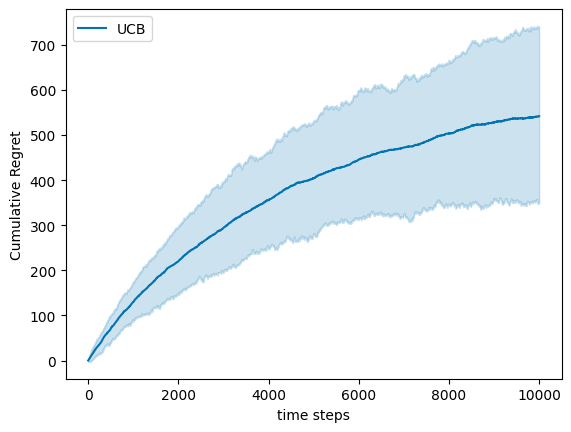

In [43]:
means = [0.5, 0.6, 0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
var = 1
delta = 0.01

arms = [Gaussian(mu=mu, var=var) for mu in means]

T = 10000  # Finite Horizon
N = 100  # Monte Carlo simulations
q = 10  #choice of percentile display

# Framework for the experiments
env = GaussianBanditEnv(means=means, var=1)

# Initialization of the agents
ucb = UCB(arms=arms)

# Run experiments
all_data = experiment(env, [ucb], Nmc=N, T=T)

# Plot results
plot_regret(regrets = all_data, logscale = False, lb = None, q = 10)

In [68]:
import math 
env = GaussianBanditEnv(means=means, var=1)
ucb = UCB(arms=arms)

def best_arm_identification_algorithm(environment, agent, delta, max_iter=10**6, verbose=False):
    data = np.zeros((1, max_iter))
    environment.reset()    
    agent.reset()
    t = 0
    condition = True
    while condition:
        action_set = environment.get_action_set()
        action = agent.get_action(action_set)
        reward = environment.get_reward(action)
        agent.receive_reward(action, reward)

        # compute instant (pseudo) regret
        means = environment.get_means()
        best_reward = np.max(means)
        data[0,t] = best_reward - reward
        t += 1
        if t > len(agent.arms):
            inf = agent.compute_condition()
            if inf > math.log(1/delta) + 3 * math.log(1 + math.log(t)):
                condition = False
    if verbose:
        print(f"The algorithm has stopped after {t} rounds")
    stopping_time = t
    most_played_arm = np.argmax(agent.count_actions)
    return agent.name(), data, most_played_arm, stopping_time

In [70]:
delta = 0.01
_, data, most_played_arm, stopping_time = best_arm_identification_algorithm(env, ucb, delta, verbose=True)

The algorithm has stopped after 40085 rounds


In [65]:
class Uniform:
    def __init__(self, arms):
      self.arms = arms
      self.K = len(arms)
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0
    
    def get_action(self, action_set):
        if self.t < self.K:
            action = self.t
        else:
            action = np.random.randint(0, self.K)
        self.t += 1
        self.count_actions[action] += 1
        self.current_action = action 
        return action_set[action]

    def receive_reward(self, action, reward):
        self.count_rewards[self.current_action] += reward

    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0

    def compute_condition(self):
        empirical_means = self.count_rewards / self.count_actions
        star_hat = np.argmax(empirical_means)
        mu_star_hat = empirical_means[star_hat]
        N_star = self.count_actions[star_hat]
        inv_N_star = 1 / N_star
        inf = np.min([((mu_star_hat - empirical_means[k])**2)/(inv_N_star + (1/self.count_actions[k])) for k in list(range(self.K)) if k!=star_hat])
        return inf

    def name(self):
        return 'Uniform' 

In [71]:
delta = 0.01
uniform = Uniform(arms=arms)
_, data, most_played_arm, stopping_time = best_arm_identification_algorithm(env, uniform, delta, verbose=True)

The algorithm has stopped after 10781 rounds


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


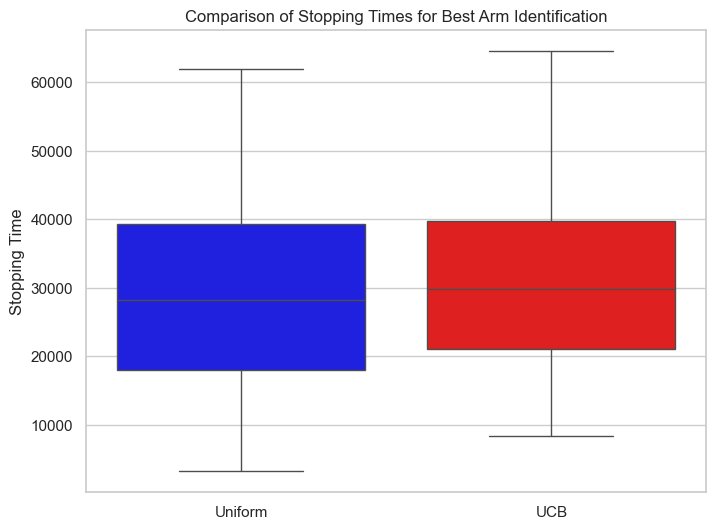

In [74]:
delta = 0.01
env = GaussianBanditEnv(means=means, var=1)
ucb = UCB(arms=arms)
uniform = Uniform(arms=arms)
stopping_times_ucb = []
stopping_times_uniform = []

for _ in tqdm(range(10**2)):
    _, data, most_played_arm, stopping_time_unif = best_arm_identification_algorithm(env, uniform, delta)
    _, data, most_played_arm, stopping_time_ucb = best_arm_identification_algorithm(env, ucb, delta)
    stopping_times_uniform.append(stopping_time_unif)
    stopping_times_ucb.append(stopping_time_ucb)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.boxplot(data=[stopping_times_uniform, stopping_times_ucb], palette=["blue", "red"])
plt.xticks([0, 1], ["Uniform", "UCB"])
plt.ylabel("Stopping Time")
plt.title("Comparison of Stopping Times for Best Arm Identification")
plt.show()